In [7]:
from src.sift import *
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Estimating the fundamental Matrix
8 points algorithm

7 points algorithm (work in progress)

Robust estimation (work in progress)


## 8-points Algorithm:

In [13]:
def FundamentalM(pairs,min_pts,norm=False):

    Hnorm = HartleysNorm(pairs)
    
    pairs = Hnorm.norm_pairs
    
    idx = np.arange(pairs[0].shape[0])
    
    idx1 = np.random.choice(idx,min_pts)

    x1 = pairs[0][idx1,0]
    y1 = pairs[0][idx1,1]

    x2 = pairs[1][idx1,0]
    y2 = pairs[1][idx1,1]

    A = np.vstack((x2*x1,x2*y1,x2,y2*x1,y2*y1,y2,x1,y1,np.ones(x2.shape)))

    U,S,V = np.linalg.svd(A.T)

    F_ = V[-1].reshape((3,3))

    U,S,V = np.linalg.svd(F_)
    
    S[-1]=0
    
    F = (U.dot(np.diag(S))).dot(V)
       
    F = Hnorm.denormalize(F)
    
    pairs = Hnorm.pairs
    
    e = F_geomError(pairs,F)
      
    return F,e,pairs[0][idx1,:],pairs[1][idx1,:]

# 7-points Algorithm

In [14]:
class mindetF:
    def __init__(self,F1,F2):
        self.F1=F1
        self.F2=F2
    def get_F(self,alpha):
        return alpha*self.F1+(1-alpha)*self.F2
        
    def get_det(self,alpha):
        return np.abs(np.linalg.det(self.get_F(alpha)))
    
    def solve(self):
        minimum = optimize.fmin(self.get_det, 0.9,full_output=False,disp=False)
        #if minimum[0]>=1e-5:print('F7 min greater than 1e-5')
        return self.get_F(minimum[0])

In [15]:
from scipy import optimize

def FundamentalM7pts(pairs,min_pts,norm=False):

    Hnorm = HartleysNorm(pairs)
    
    pairs = Hnorm.norm_pairs
    
    idx = np.arange(pairs[0].shape[0])
    idx1 = np.random.choice(idx,min_pts)

    x1 = pairs[0][idx1,0]
    y1 = pairs[0][idx1,1]

    x2 = pairs[1][idx1,0]
    y2 = pairs[1][idx1,1]


    A = np.vstack((x2*x1,x2*y1,x2,y2*x1,y2*y1,y2,x1,y1,np.ones(x2.shape)))

    U,S,V = np.linalg.svd(A.T)

    F1 = V[-1].reshape((3,3))
    
    F2 = V[-2].reshape((3,3))
    
    f = mindetF(F1,F2)

    
    F = Hnorm.denormalize(F)
    
    pairs = Hnorm.pairs
    
    e = F_geomError(pairs,F)
    
   

    return F,e,pairs[0][idx1,:],pairs[1][idx1,:]

# Hartley's normalization

In [16]:
class HartleysNorm:
    def __init__(self,pairs):
        self.pairs=pairs
        self.Tl = self.get_T(hmg(pairs[0][:,:2]))
        self.Tr = self.get_T(hmg(pairs[1][:,:2]))
        self.norm_pairs = hmg(pairs[0][:,:2]).dot(self.Tl),hmg(pairs[1][:,:2]).dot(self.Tr)
        
    def denormalize(self,F):
        return ((self.Tl.T).dot(F)).dot(self.Tr)
    
    def get_T(self,data):
        ml = data

        n = data.shape[0]

        ml_ = np.mean(ml,axis=0)

        sl = np.sqrt(np.sum((ml - ml_)**2)/(2*n))

        return np.array([[1/sl,0,(-1/sl)*ml_[0]],[0,1/sl,(-1/sl)*ml_[1]],[0,0,1]])


# Robust Estimation

In [19]:
'''
p - probability of being an inlier
k - number of samples
S - number of required trials
'''
def RANSAC2(pairs,min_pts=4,p=0.1,P=.99,th=100,type_='affine',max_it=50000):
    print("Starting RANSAC:")
    S = np.round(np.log(1-P)/(np.log(1-p**min_pts))).astype(int)

    best_fit=0

    for i in range(S):
        if p>0.9:
            break
            
        if type_=='affine':
            w,e,x1,x2 = Affine(pairs,min_pts)
        if type_ == 'F':
            w,e,x1,x2 = FundamentalM(pairs,min_pts,norm=False)
        else:
            w,e,x1,x2 = Homography(pairs,min_pts)

        inliers = np.sum(e<th**2)
        

        if best_fit<inliers:
            best_fit = inliers
            best_w = w
            best_e = np.mean(e)
            best_x1 = x1
            best_x2 = x2
            idx = e<th**2          
            p = best_fit/pairs[0].shape[0]
            print('Iteration: {}'.format(i))
            print(np.mean(e),p,best_fit,pairs[0].shape[0])         
            S += np.round(np.log(1-P)/(np.log(1-p**min_pts))).astype(int)
        
        if i>max_it:
            break

    best_x1 = x1
    best_x2 = x2
    print('RANSAC error: {}'.format(best_e))

    if type_=='affine':
        H = np.reshape(best_w,(2,3))
    elif type_=='F':
        H = np.reshape(best_w,(3,3))
    else:
        H = np.reshape(best_w,(3,3))

    return H,idx

# Helper functions

In [17]:
def hmg(x):
    n = x.shape[0]
    ones = np.ones(n)
    return np.vstack((x.T,ones)).T

In [18]:
def F_geomError(pairs,F):
    
    e1 = (F.dot(hmg(pairs[1][:,:2]).T)).T
    
    e2 = ((hmg(pairs[0][:,:2])).dot(F))

    d1 = np.sum(e1*hmg(pairs[0][:,:2]),axis=1)/np.sqrt(e1[:,0]**2+e1[:,1]**2)
    
    d2 = np.sum(e2*hmg(pairs[1][:,:2]),axis=1)/np.sqrt(e2[:,0]**2+e2[:,1]**2)
        
    return ((d1**2+d2**2)).T



In [20]:
def get_epipoles(F):
    U,S,V = np.linalg.svd(F)
    el = U[-1]
    er = V[-1]
    return el,er

In [21]:
def plot_epipoles(im1,pairs,F,idx,side='left'):
    img1 = im1.img1_
    
    pairs1 = (pairs[0][idx],pairs[1][idx])
    
    l = (F.dot(hmg(pairs1[1][:,:2]).T)).T
    
    if side=='right':
        pairs1 = (pairs[1][idx],pairs[0][idx])
        l = (F.T.dot(hmg(pairs1[1][:,:2]).T)).T
        
    num =  pairs1[0].shape[0]

    H,W = img1.shape

    l = l[:,[1,2]]/l[:,0][:,np.newaxis]

    x = np.arange(W)
    lines = []
    for i in range(num):
        y = -l[i,0]*x -l[i,1]
        keep = (y<H-1)&(y>0)
        lines.append((x[keep],y[keep]))

    plt.imshow(img1,**{'cmap':'gray'})

    for i in range(num):
        plt.scatter(pairs1[0][i,1],pairs1[0][i,0],c='red',s=1)
        plt.plot(lines[i][0],lines[i][1],**{'linestyle':'-','linewidth':0.5})
    plt.show()

# Examples/tests

## House

In [44]:
%%capture
im1 = sift(os.path.abspath('img/house/house22.jpg'),type_='homography',N=3,Red=2,s=5,sig=1.6,RANSAC_th=50,RANSAC_p=0.2)
im4 = sift(os.path.abspath('img/house/house23.jpg'),type_='homography',N=3,Red=2,s=5,sig=1.6,RANSAC_th=50,RANSAC_p=0.2)

im1==im4

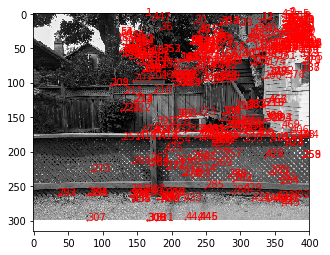

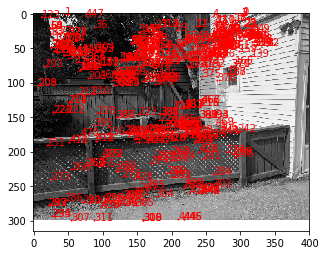

In [45]:
im1.plot('best_kp')
im4.plot('best_kp')

Starting RANSAC:
Iteration: 1
11451.425929085357 0.025477707006369428 12 471
Iteration: 2
6143.019932905537 0.029723991507430998 14 471
Iteration: 4
1986.2166430447767 0.04246284501061571 20 471
Iteration: 5
1330.5735690706606 0.07643312101910828 36 471
Iteration: 8
2609.7440183208464 0.09978768577494693 47 471
Iteration: 12
5885.076704357648 0.12314225053078556 58 471
Iteration: 24
1993.6789621469295 0.14861995753715498 70 471
Iteration: 33
629.3821208974375 0.27388535031847133 129 471
RANSAC error: 629.3821208974375


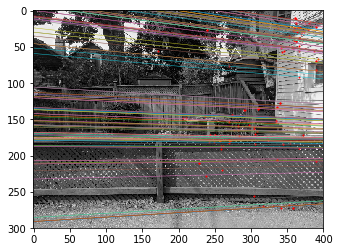

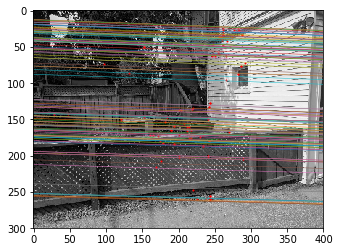

In [46]:
pairs = (im1.best_kp,im4.best_kp)
F,idx = RANSAC2(pairs,min_pts=8,p=0.4,P=.99,th=5,type_='F',max_it=1000)

plot_epipoles(im1,pairs,F,idx,'left')
plot_epipoles(im4,pairs,F,idx,'right')

## Pepsi:

In [128]:
%%capture
im1 = sift(os.path.abspath('img/pepsi1.jpg'),type_='homography',peak_th=0.03,crt=0.8,N=3,Red=2,s=5,sig=1.5,RANSAC_th=50)
im4 = sift(os.path.abspath('img/pepsi2.jpg'),type_='homography',peak_th=0.03,crt=0.8,N=3,Red=2,s=5,sig=1.5,RANSAC_th=50)

im1==im4

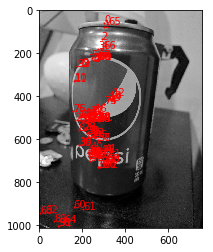

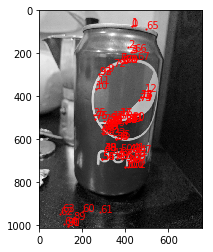

In [129]:
im1.plot('best_kp')
im4.plot('best_kp')

Starting RANSAC:
Iteration: 1
66234.486864101 0.019417475728155338 2 103
Iteration: 3
6738.802282260036 0.0970873786407767 10 103
Iteration: 23
2819.119670936801 0.13592233009708737 14 103
Iteration: 34
7007.47628087829 0.17475728155339806 18 103
Iteration: 168
2067.032627388599 0.2621359223300971 27 103
Iteration: 424
1386.633440844469 0.3786407766990291 39 103
RANSAC error: 1386.633440844469


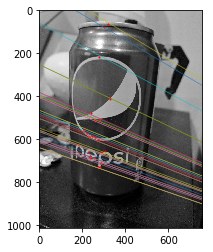

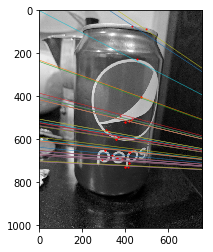

In [130]:
pairs = (im1.best_kp,im4.best_kp)
F,idx = RANSAC2(pairs,min_pts=8,p=0.1,P=.99,th=10,type_='F',max_it=5000)

plot_epipoles(im1,pairs,F,idx,'left')
plot_epipoles(im4,pairs,F,idx,'right')

## Uoft:

In [137]:
%%capture
im1 = sift(os.path.abspath('img/uoft6.jpg'),type_='homography',peak_th=0.05,crt=0.8,N=2,Red=3,s=5,sig=1.5,RANSAC_th=50)
im4 = sift(os.path.abspath('img/uoft4.jpg'),type_='homography',peak_th=0.05,crt=0.8,N=2,Red=3,s=5,sig=1.5,RANSAC_th=50)

im1==im4

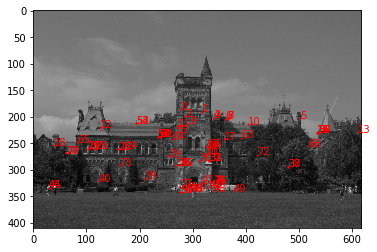

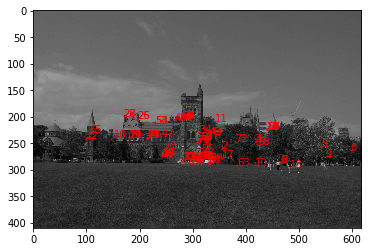

In [138]:
im1.plot('best_kp')
im4.plot('best_kp')

Starting RANSAC:
Iteration: 3
84136.25987705958 0.0625 5 80
Iteration: 11
19858.455542119427 0.1375 11 80
Iteration: 14
29139.413522450974 0.1625 13 80
Iteration: 18
12539.203666653466 0.1875 15 80
Iteration: 29
9369.329980432907 0.2125 17 80
Iteration: 64
9641.28232239252 0.2875 23 80
Iteration: 516
13184.450353385817 0.3 24 80
Iteration: 873
4873.107066668771 0.325 26 80
Iteration: 2907
29187.11106664313 0.3375 27 80
Iteration: 3426
15718.079031684092 0.35 28 80
Iteration: 4096
7207.7602723733235 0.3875 31 80
RANSAC error: 7207.7602723733235


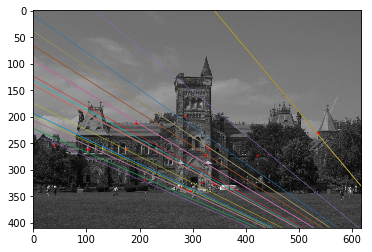

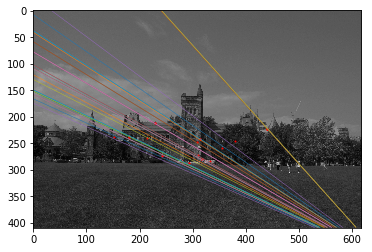

In [139]:
pairs = (im1.best_kp,im4.best_kp)
F,idx = RANSAC2(pairs,min_pts=8,p=0.1,P=.99,th=20,type_='F',max_it=5000)

plot_epipoles(im1,pairs,F,idx,'left')
plot_epipoles(im4,pairs,F,idx,'right')

# Work in progress:

In [ ]:
def computeE(el):
    zeros = np.zeros((3,3))
    e = np.array([[0,-el[2],el[1]],[el[2],0,-el[0]],[-el[1],el[0],0]])
    e1 = np.hstack([e,zeros,zeros])
    e2 = np.hstack([zeros,e,zeros])
    e3 = np.hstack([zeros,zeros,e])
    return np.vstack((e1,e2,e3))

#284

In [ ]:
def computeA(pairs):
    x1 = pairs[0][:,0]
    y1 = pairs[0][:,1]

    x2 = pairs[1][:,0]
    y2 = pairs[1][:,1]


    return np.vstack((x2*x1,x2*y1,x2,y2*x1,y2*y1,y2,x1,y1,np.ones(x2.shape))).T


In [ ]:
def AlgError(el):
    r = 8
    A = computeA(pairs)
    
    E = computeE(el)

    U,S,V = np.linalg.svd(E)

    U_ = U[:,:r]

    _,_,V1 = np.linalg.svd(A.dot(U_))
    x_ = V1[-1]

    F_ = (U_.dot(x_))
    
    return A*F_[np.newaxis,:]


In [ ]:
def Jacobian(fun,x0,step):
    delta = np.zeros(x0.shape[0])    
    grad = np.zeros((9,9))
    for i in np.arange(x0.shape[0]):
        for j in np.arange(x0.shape[0]):
        delta[i] = step
        x2 = x0 + delta
        x1 = x0 - delta
        increment2 = fun(x2)
        increment1 = fun(x1)
        grad[i,j]=(increment2-increment1)/(2*step)
        delta[i] -= step  

    return np.array(grad)